In [1]:
#!pip install pygad

Modified version of pygad samples. https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#life-cycle-of-pygad <br>
Model inspired and modified from http://uhurumkate.blogspot.com/2018/06/tiny-model-for-mnist-dataset.html

This is a small project trying different methods to aid premature convergence. In my finding, loss functions such as cross-entropy loss, mean squared error and weighted f1 loss do terribly in GA. Only L1 loss can yield a good enough result. As for the network, contrary to my hypothesis, a small network (with ~2k param that achieves 96% acc with gradient descent) doesn't outperform a larger network. Or, a larger network like Resnet50 converges at 30% while a CNN with 8k param can go up to 72% with a decaying mutation rate. In my finding, epoch (repeat training on the same set of data), batch_size, mutation rate, num_parents_mating, keep_parents, num_solution all have played a role in aiding premature convergence. Of cause, the higher the num_solution the better as it increases diversity. Likewise, keep_parents is best to set to 0 for the same reason. The balance between epoch and batch_size is an art of computation time and result. Though, it can be addressed with a simple least square method to eval its oscillation and iteration vs result tradeoff. Finally, mutation rate and num_parents_mating have to be resolved by the GA. As when it first gein, we want large numbers, but as it continues we want it to be smaller (think of it as learning rate). It can be resolved with a decaying function (like decaying learning rate), but why not use GA?

This code is using some properties of the TensorFlow and pygad library. Such like TensorFlow keeps its model weight and pygad re-initial its traits when called again after it's finished. This code also contains orphans as they may be the relic of the previous version or as a debugging tool.

In [2]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import losses, datasets, layers, optimizers, Sequential, metrics
import pygad.kerasga
import numpy
import math
import pygad

# Hyper param

In [3]:
acc_meter = tf.keras.metrics.Accuracy()

#Instead of training a entire dataset, do small batches.
sgd_like = True

#introduce new population when stucked. Often time it'll stuck in local optima.
introduce_new_pop = False

#increase batch size when stcuked.
dynamic_batch_size = True

#reshuffle
reshuffle = True

In [4]:
#num cycles
num_generations = 50

#num soltions
num_solution= 24

#the following two param only works if introduce_new_pop = True
#Maxium cycles stuck before introducing new population to the pool.
max_cycles_stucked = 20

#The follow two param have effect only when sgd_like = True
#number of cycles you want on a single batch. 
epoch = 10
#number of samples per batch
batch_size = 500

#number batch increase feed into prediction. only have effect if sgd_like = True
#Ex. batch size 1500 -> 1500 + 500 = 2000. Note that some data will be lose during the process
batch_increase = 1024

#reshuffle every n cycles
reshuffle_per = (int(60000/batch_size) -1) * epoch #so that it's insync with epoch

#Typical pygad params
num_parents_mating = int(num_solution * .5) #half parents mating
parent_selection_type = "sss"
mutation_type="adaptive"
mutation_higer = 90
mutation_lower = 80
mutation_num_genes=(mutation_higer, mutation_lower)
keep_parents = 0

# dataset

In [5]:
#load mnist dataset
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
#normalize data
X_train = 2*tf.convert_to_tensor(X_train, tf.float32)/255.-1
#[b, 28, 28] -> [b, 28, 28, 1]
X_train = tf.reshape(X_train, (-1, 28,28,1))
X_test = 2*tf.convert_to_tensor(X_test, tf.float32)/255.-1
X_test = tf.reshape(X_test, (-1, 28,28,1))
y_train = tf.convert_to_tensor(y_train, tf.int32)
#[b] -> [b, 10]
y_train = tf.one_hot(y_train, 10)
y_test = tf.convert_to_tensor(y_test, tf.int32)
y_test = tf.one_hot(y_test, 10)

# Model

In [6]:
model = Sequential([
#input layer
layers.Convolution2D(15, (3, 3), activation='relu', input_shape=(28,28,1)),
layers.BatchNormalization(momentum=0.1),
layers.AveragePooling2D(2),
#convo layers1
layers.Convolution2D(10,(1,1), activation='relu'),
layers.BatchNormalization(momentum=0.1),
#convo layers2
layers.AveragePooling2D(2),
layers.Convolution2D(5,(3,3), activation='relu'),
layers.BatchNormalization(momentum=0.1),
#fully connected layer1
layers.Dense(128, activation='relu'),
layers.Dense(64, activation='relu'),
layers.Dense(32, activation='relu'),
layers.Flatten(),
#output layer
layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 15)        150       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 15)        60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 10)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 10)        40        
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 10)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 5)           4

In [8]:
#l1 loss.
def some_loss(y_true, y_pred):
  return tf.reduce_mean(tf.math.abs(y_pred - y_true))

In [9]:
acc_meter.update_state(tf.argmax(model(X_test[:1000], training=False), axis=1), tf.argmax(y_test[:1000], axis=1))
print("Accuracy on testing set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on testing set:{err}%".format(err=(1-acc_meter.result().numpy())*100))
acc_meter.update_state(tf.argmax(model(X_train[:1000], training=False), axis=1), tf.argmax(y_train[:1000], axis=1))
print("Accuracy on training set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on training set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

Accuracy on testing set:9.200000017881393%
Error rate on testing set:90.7999999821186%
Accuracy on training set:9.549999982118607%
Error rate on training set:90.4500000178814%


loss

In [11]:
#A method always modifing X_train_sgd and y_train_sgd
def make_batch(batch_size):
  idx = numpy.random.permutation(len(X_train))
  global X_train_sgd, y_train_sgd
  if len(X_train) % batch_size == 0:
    X_train_sgd = tf.reshape(X_train.numpy()[idx], [-1, batch_size, 28, 28, 1])
    y_train_sgd = tf.reshape(y_train.numpy()[idx], [-1, batch_size, 10])
  else:
    #Remove some samples if can't rehape 
    len_remove = len(X_train) % batch_size
    X_train_sgd = tf.reshape(X_train.numpy()[idx][:-len_remove], [-1, batch_size, 28, 28, 1])
    y_train_sgd = tf.reshape(y_train.numpy()[idx][:-len_remove], [-1, batch_size, 10])

lsm can be use to eval the effectiness of the hyper param. If the fitness oscillate, it'll gain a low score. If it is not going up, also a low score. Only the ones are health are getting a positive high score. 

In [12]:
def lsm(arr):
    x = numpy.arange(len(arr))
    n = len(arr)
    pt1 = (n * numpy.sum(arr * x)) - (numpy.sum(x)*numpy.sum(arr))
    pt2 = n * numpy.sum(x ** 2) - (numpy.sum(x)**2)
    m = pt1 / pt2
    return m
    #b = (numpy.sum(arr) - (m*numpy.sum(x))) / n
    #return m * x + b

In [13]:
import matplotlib.pyplot as plt

In [14]:
#create inital training set
X_train_sgd = []
y_train_sgd = []
make_batch(batch_size)

# Fitness 

In [15]:
keras_ga = pygad.kerasga.KerasGA(model=model,
                                 num_solutions=num_solution)

In [16]:
#Some helper varibles
i = 0
cycles_stucked = 0
k=0
tmp = 0

#fitness_func uses acc matrix as fitness.
def fitness_func(solution, sol_idx):

    global model, i, cycles_stucked ,X_train, y_train, k, y_train_sgd, X_train_sgd
    solution_fitness = 0
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)

    model.set_weights(weights=model_weights_matrix)

    #if perfer to use loss instead
    #solution_fitness = 1/cce(model.predict(X_train), y_train).numpy()

    if sgd_like == True:
      solution_fitness = some_loss(model(X_train_sgd[k], training=False), y_train_sgd[k]).numpy()
    else:
      solution_fitness = some_loss(model(X_train, training=False), y_train).numpy()
    #print(solution_fitness)
    #if result is invalid, return a very small number, where its trait will die in iterations
    if numpy.isnan(solution_fitness):
      return 1E-20
    #inverse relationship with the loss.
    else:
      return 1/ solution_fitness

In [17]:
ga_instance = []
params = [epoch, batch_size, mutation_higer, mutation_lower, num_parents_mating]
def param_fitness_func(solution, solution_idx):
    
    global epoch, batch_size, mutation_higer, mutation_lower, num_parents_mating, reshuffle_per, ga_instance

    #set hyper param. Min, Max to make sure they're within range
    epoch = max(min(300, solution[0]), 1)
    batch_size = max(min(solution[1], 60000), 1)
    mutation_higer = max(min(solution[2], 99), 2)
    mutation_lower = max(min(solution[3], mutation_higer -1 ), 1)
    num_parents_mating = max(min(solution[4], num_solution), 1)
    print(solution)
    reshuffle_per = (int(60000/batch_size) -1) * epoch
    
    #Flatten the model as a 1D numpy array and the create a 2D numpy array of n copy of model vector
    initial_population = numpy.tile(pygad.kerasga.model_weights_as_vector(model), (num_solution, 1))
    
    ga_instance = pygad.GA(num_generations=epoch,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       keep_parents=keep_parents,
                       mutation_type=mutation_type,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_func,
                       mutation_num_genes=mutation_num_genes,
                       on_generation=callback_generation)

    ga_instance.run()
    
    net_solution, fitness, _ = ga_instance.best_solution()
    best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                  weights_vector=net_solution)
    model.set_weights(best_solution_weights)
    
    slope = lsm(getattr(ga_instance, 'best_solutions_fitness'))
    
    #use least squared method to eval the effectiness of the hyper param
    #fitness is the fitness of the network. Due to the nature of the tensorflow, the weight stays the same until next update
    return fitness * slope

# Crossover function

In [18]:
def crossover_func(parents, offspring_size, ga_instance):
  global cycles_stucked
  offspring = []
  idx = 0

  #Standard offspring method from https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#life-cycle-of-pygad
  while len(offspring) != offspring_size[0]:
    parent1 = parents[idx % parents.shape[0], :].copy()
    parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
    random_split_point = numpy.random.choice(range(offspring_size[0]))
    parent1[random_split_point:] = parent2[random_split_point:]
    offspring.append(parent1)
    idx += 1

  offspring = numpy.array(offspring)
  
  if introduce_new_pop and cycles_stucked == max_cycles_stucked:
    #craete new parents with new random variables
    new_parents = tf.random.truncated_normal(offspring.shape).numpy()
    #create an array that contain both offspring and new parents
    new_parents = numpy.append(new_parents, offspring)
    #shuffle
    numpy.random.shuffle(new_parents)
    #rehspae
    new_parents = new_parents.reshape(-1, offspring.shape[1])
    offspring = new_parents[:len(offspring)]
    print('New gene added')
    #Only want to do this once
    cycles_stucked = 0

  return numpy.array(offspring)

# callback

In [19]:
def callback_generation(ga_instance):
    global i, k, cycles_stucked, tmp, X_train_sgd, mutation_lower, decay, epoch
    
    fitness = ga_instance.best_solution()[1]
#    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
#    print("Fitness    = {fitness}".format(fitness=fitness))

    if fitness == tmp:
      cycles_stucked += 1
      if dynamic_batch_size and cycles_stucked == max_cycles_stucked:
        #increase batch size. Up until only 1 batch with all samples avaliable
        make_batch(min(X_train_sgd.shape[1]+batch_increase, X_train_sgd.shape[0]*X_train_sgd.shape[1]))
        print("Batch size increased -> new shape: ",X_train_sgd.shape)
        k = numpy.random.randint(0, len(X_train_sgd)-1)
        #Otherwise introduce_new_pop from cross over will never be True. 
        if not introduce_new_pop:
          #keep track of cycles stucked
          cycles_stucked = 0
    else:
      cycles_stucked = 0

    #keep track of generation
    i += 1
    if sgd_like == True:
      if i % (1 * epoch) == 0:
        #select random data from reshaped dataset to train
        k = numpy.random.randint(0, len(X_train_sgd)-1)
#        print("Generation = {generation}".format(generation=ga_instance.generations_completed))
#        print('new set')
    if reshuffle:
      if i % (1 * reshuffle_per) == 0:
        #select random data from reshaped dataset to train
        make_batch(X_train_sgd.shape[1])
#        print('reshuffled')
    #update tmp
    tmp = fitness

In [20]:
#Call back function for param genetations
def param_callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

#  Run

In [21]:
# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
# Use the pre-existing model weight as init population. 
initial_population = numpy.tile(pygad.kerasga.model_weights_as_vector(model), (num_solution, 1))

In [22]:
param_ga_instance = pygad.GA(num_generations=100,
                       sol_per_pop=5,
                       num_parents_mating=2,
                       num_genes=5,
                       fitness_func=param_fitness_func,
                       #only wants integer
                       gene_type=int,
                       #top to bottom epoch, batch_size, mutation_higer, mutation_lower, num_parents_mating
                       #to limit range
                       gene_space = [{'low': 1, 'high': 300}, 
                                     {'low': 1, 'high': 60000}, #60000 is num training data of mnist
                                     {'low': 2, 'high': 99},
                                     {'low': 1, 'high': 98},
                                     {'low': 1, 'high': num_solution}],
                       on_generation=param_callback_generation
                        )

param_ga_instance.run()

/home/gsd/.local/lib/python3.9/site-packages/pygad/pygad.py:469: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))
/home/gsd/.local/lib/python3.9/site-packages/pygad/pygad.py:621: UserWarning: The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.
  if not self.suppress_warnings: warnings.warn("The steady-state parent (sss) selection operator is used de

[  262 53702    30    44     5]


<ipython-input-19-80ea1efe9a88>:31: RuntimeWarning: divide by zero encountered in long_scalars
  if i % (1 * reshuffle_per) == 0:


[  281 16563    49    20     2]
[  104 50332     2    93     8]
[  131 31733    45    10    15]
[  240 21563     6    55    17]
[  262 53702    29    44     2]
[   13 53702    30    44     5]
[  262 53702    30     5     2]
Generation = 1
[  262 53702    29    44     2]
[   13 53702    30    44     5]
[  262 53702    30     5     2]
Fitness    = 0.07548352094867761
[   13 53702    30    18     5]
[  262 53702    32    44     5]
[   13 21197    30    44     5]
Generation = 2
[   13 53702    30    18     5]
[  262 53702    32    44     5]
[   13 21197    30    44     5]
Fitness    = 0.3616519231815542
[   13 17536    30    18     5]
[   13 53702    44    44     5]
[   92 53702    30    18     5]
Generation = 3
[   13 17536    30    18     5]
[   13 53702    44    44     5]
[   92 53702    30    18     5]
Fitness    = 0.9667871484186336
[  149 17536    30    18     5]
[   13 21197    30    44     2]
[   29 21197    30    18     5]
Generation = 4
[  149 17536    30    18     5]
[   13 2119

# Stat

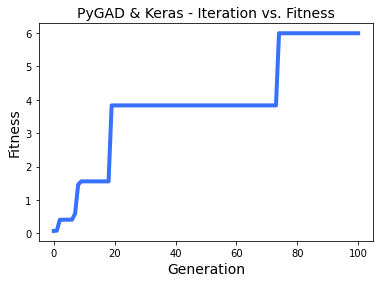

Fitness value of the best solution = 32.28813571350302
Index of the best solution : 8


In [23]:
# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
param_ga_instance.plot_fitness(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)
model.set_weights(best_solution_weights)

In [24]:
#update acc matrix for testing data
acc_meter.update_state(tf.argmax(model(X_test, training=False), axis=1), tf.argmax(y_test, axis=1))
test_acc = acc_meter.result().numpy()*100
print("Accuracy on testing set:{acc}%".format(acc=test_acc))
print("Error rate on testing set:{err}%".format(err=(100-test_acc)))
#update acc matrix for training data
acc_meter.update_state(tf.argmax(model(X_train, training=False), axis=1), tf.argmax(y_train, axis=1))
train_acc = acc_meter.result().numpy()*100
print("Accuracy on training set:{acc}%".format(acc=train_acc))
print("Error rate on training set:{err}%".format(err=(100-train_acc)))

Accuracy on testing set:72.45833277702332%
Error rate on testing set:27.541667222976685%
Accuracy on training set:82.27083086967468%
Error rate on training set:17.729169130325317%
